In [1]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import os
from os import path

In [2]:
semester = 'S19'
BASE_PATH = os.path.join('data', 'Release', semester)
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
TEST_PATH = os.path.join(BASE_PATH, 'Test')

In [3]:
train_ps2 = ProgSnap2Dataset(os.path.join(TRAIN_PATH, 'Data')) 

In [4]:
# The early dataset will help us to feature extraction,
# but we're not actually predicting anything here
# Note: we could still use this for model training if desired.
early_train = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early_train.head()

,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually,Label
0,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,1,8,True,False
1,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,3,6,True,False
2,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,5,7,True,False
3,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,12,2,True,True
4,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,13,17,True,False


In [5]:
# The late dataset contains the problems that we're actually predicting for.
# The training portion of it includes labels.
late_train = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))
late_train.head()

,SubjectID,AssignmentID,ProblemID,Label
0,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,41,True
1,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,43,False
2,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,44,False
3,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,46,False
4,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,49,False


In [6]:
X_train_base = late_train.copy().drop('Label', axis=1)
y_train = late_train['Label'].values

In [7]:
problem_encoder = OneHotEncoder().fit(X_train_base[PS2.ProblemID].values.reshape(-1, 1))

In [8]:
problem_encoder.transform(X_train_base[PS2.ProblemID].values.reshape(-1, 1)).toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [25]:
def extract_instance_features(instance, early_df):
    instance = instance.copy()
    subject_id = instance[PS2.SubjectID]
    early_problems = early_df[early_df[PS2.SubjectID] == subject_id]
    # Extract very naive features about the student
    # (without respect to the problem bring predicted)
    # Number of early problems attempted
    instance['ProblemsAttempted'] = early_problems.shape[0]
    # Percentage of early problems gotten correct eventually
    instance['PercCorrectEventually'] = np.mean(early_problems['CorrectEventually'])
    # Median attempts made on early problems
    instance['MedAttempts'] = np.median(early_problems['Attempts'])
    # Max attempts made on early problems
    instance['MaxAttempts'] = np.max(early_problems['Attempts'])
    # Percentage of problems gotten correct on the first try
    instance['PercCorrectFirstTry'] = np.mean(early_problems['Attempts'] == 1)
    instance = instance.drop('SubjectID')
    return instance

In [26]:
extract_instance_features(X_train_base.iloc[0], early_train)

AssignmentID                  494
ProblemID                      41
ProblemsAttempted              30
PercCorrectEventually           1
MedAttempts                   7.5
MaxAttempts                    30
PercCorrectFirstTry      0.133333
Name: 0, dtype: object

In [61]:
def extract_features(X, early_df, scaler, is_train):
    # First extract performance features for each row
    features = X.apply(lambda instance: extract_instance_features(instance, early_df), axis=1)
    # Then one-hot encode the problem_id and append it
    problem_ids = problem_encoder.transform(features[PS2.ProblemID].values.reshape(-1, 1)).toarray()
    # Then get rid of nominal features
    features.drop([PS2.AssignmentID, PS2.ProblemID], axis=1, inplace=True)
    # Then scale the continuous features, fitting the scaler if this is training
    if is_train:
        scaler.fit(features)
    features = scaler.transform(features)
    
    # Return continuous and one-hot features together
    return np.concatenate([features, problem_ids], axis=1)

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = extract_features(X_train_base, early_train, scaler, True)

In [63]:
print(X_train.shape)
X_train[:2,]

(4315, 25)


array([[ 0.52818587,  0.55466436,  2.31871327,  0.61819333, -1.04038138,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.52818587,  0.55466436,  2.31871327,  0.61819333, -1.04038138,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

## Evaluate the Training Performance of the Model

In [64]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV()
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)

In [65]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

print(classification_report(train_predictions, y_train))
print('AUC: ' + str(roc_auc_score(train_predictions, y_train)))
print('Macro F1: ' + str(f1_score(train_predictions, y_train, average='macro')))

              precision    recall  f1-score   support

       False       0.24      0.57      0.34       449
        True       0.94      0.79      0.86      3866

    accuracy                           0.77      4315
   macro avg       0.59      0.68      0.60      4315
weighted avg       0.87      0.77      0.80      4315

AUC: 0.6808643568451822
Macro F1: 0.5972190002761668


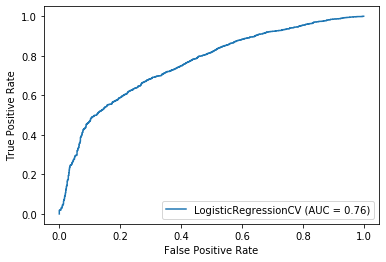

In [66]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, X_train, y_train)

## Evaluate the CV Performance of the Model

In [70]:
from sklearn.model_selection import cross_validate

model = LogisticRegressionCV()
cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=['accuracy', 'f1_macro', 'roc_auc'])
print(f'Accuracy: {np.mean(cv_results["test_accuracy"])}')
print(f'AUC: {np.mean(cv_results["test_roc_auc"])}')
print(f'Macro F1: {np.mean(cv_results["test_f1_macro"])}')

Accuracy: 0.7527256810174443
AUC: 0.7571991447985809
Macro F1: 0.5545637535165886


## Predict on the test data

In [71]:
early_test = pd.read_csv(os.path.join(TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(TEST_PATH, 'late.csv'))
X_test = extract_features(late_test, early_test, scaler, False)

In [74]:
X_test.shape

(1397, 25)

In [76]:
model = LogisticRegressionCV()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [77]:
predictions

array([ True,  True,  True, ...,  True, False, False])

In [79]:
predictions_df = late_test.copy()
predictions_df['Label'] = predictions
predictions_df

,SubjectID,AssignmentID,ProblemID,Label
0,0503bf609757acf2e75aa8cbc0d8323b,494.0,41,True
1,0503bf609757acf2e75aa8cbc0d8323b,494.0,43,True
2,0503bf609757acf2e75aa8cbc0d8323b,494.0,44,True
3,0503bf609757acf2e75aa8cbc0d8323b,494.0,46,True
4,0503bf609757acf2e75aa8cbc0d8323b,494.0,49,True
...,...,...,...,...
1392,f78a3fbff320d57c670af3fcdafebc7e,502.0,64,False
1393,f78a3fbff320d57c670af3fcdafebc7e,502.0,70,False
1394,f78a3fbff320d57c670af3fcdafebc7e,502.0,71,True
1395,f78a3fbff320d57c670af3fcdafebc7e,502.0,112,False


In [80]:
# We don't have the test labels - you have to submit to evaluate it

In [81]:
path = os.path.join('data', 'Prediction')
os.makedirs(path, exist_ok=True)
predictions_df.to_csv(os.path.join(path, 'basic_LR.csv'))